# Visualization demo

In [1]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull
from skimage.measure import regionprops
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set up the paths
base_path = '/home/unix/jiahao/wanglab/Data/Analyzed/sample-dataset-final/tissue-2D'
output_path = os.path.join(base_path, 'output')
expr_path = os.path.join(base_path, 'expr')
image_path = os.path.join(base_path, 'images')
figure_path = os.path.join(base_path, 'figures')
if not os.path.exists(figure_path):
    os.mkdir(figure_path)

# Load the data with cell type annotation
adata = sc.read_h5ad(os.path.join(expr_path, '2023-11-27-mAD_64_cp.h5ad'))
adata

AnnData object with n_obs × n_vars = 12100 × 64
    obs: 'area', 'x', 'y', 'seg_label', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'leiden', 'cell_type'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'AD_morph', 'cell_type_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

## Spatial map

In [3]:
# Get the color palette
cpl = sns.color_palette('tab20', n_colors=adata.obs['leiden'].nunique())
cmap = ListedColormap(cpl.as_hex())

In [4]:
# Generate convex hull from segmentation
def get_qhulls(labels):
    hulls = []
    coords = []
    centroids = []
    print('Geting Convex Hull...')
    for i, region in enumerate(tqdm(regionprops(labels))):
        try:
          hulls.append(ConvexHull(region.coords))
        except:
          print(f"Cannot generate convex hull for region {region.label}")
          hulls.append([])
        coords.append(region.coords)
        centroids.append(region.centroid)
    num_cells = len(hulls)
    print(f"Used {num_cells} / {i + 1}")
    return hulls, coords, centroids

In [5]:
# Store morphology data
current_sample_id = 'AD'

current_key = f"{current_sample_id}_morph"
adata.uns[current_key]['qhulls'], adata.uns[current_key]['coords'], adata.uns[current_key]['centroids'] = get_qhulls(adata.uns[current_key]['label_img'])

adata.uns[current_key]['good_cells'] = adata.obs.index.astype(int)
adata.uns[current_key]['colors'] = adata.obs['cell_type'].cat.codes.values

Geting Convex Hull...


  0%|          | 0/12258 [00:00<?, ?it/s]

Used 12258 / 12258


In [6]:
# Convert convexhull to polygon
def hull_to_polygon(hull, hatch=None):
    cent = np.mean(hull.points, 0)
    pts = []
    for pt in hull.points[hull.simplices]:
        pts.append(pt[0].tolist())
        pts.append(pt[1].tolist())
    pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                      p[0] - cent[0]))
    pts = pts[0::2]  # Deleting duplicates
    pts.insert(len(pts), pts[0])
    k = 1.1

    if hatch is not None:
        poly = Polygon(k * (np.array(pts) - cent) + cent, edgecolor='k', linewidth=1, fill=False, hatch=hatch)
    else:
        poly = Polygon(k * (np.array(pts) - cent) + cent, edgecolor='k', linewidth=1)
    # poly.set_capstyle('round')
    return poly

In [7]:
adata.uns['AD_morph']['label_img'].shape

(11289, 9840)

In [8]:
# Plot 2D polygon figure indicating cell typing and clustering
def plot_poly_cells_cluster_by_sample(adata, sample, cmap, linewidth=0.1,
                            show_plaque=None, show_tau=None, show_gfap=False, bg_color='#ededed', 
                            figscale=10, save=False, show=True, save_as_real_size=False,
                            output_dir='./figures', rescale_colors=False, alpha=1, vmin=None, vmax=None):
    
    sample_key = f"{sample}_morph"
    label_img = adata.uns[sample_key]['label_img']
    hulls = adata.uns[sample_key]['qhulls']
    colors = adata.uns[sample_key]['colors']
    good_cells = adata.uns[sample_key]['good_cells']

    if save_as_real_size:
        plt.figure(figsize=(label_img.shape[0]/1000, label_img.shape[1]/1000), dpi=100)
    else:
        plt.figure(figsize=(label_img.shape[0]/1000 * figscale, label_img.shape[1]/1000 * figscale), dpi=100)

    polys = []
    for h in hulls:
        if h == []:
            polys.append([])
        else:
            polys.append(hull_to_polygon(h))

    if good_cells is not None:
        others = [p for i, p in enumerate(polys) if i not in good_cells and p != []]
        polys = [p for i, p in enumerate(polys) if i in good_cells]

    p = PatchCollection(polys, alpha=alpha, cmap=cmap, edgecolor='k', linewidth=linewidth, zorder=3)

    other_cmap = sns.color_palette([bg_color])
    other_cmap = ListedColormap(other_cmap)
    o = PatchCollection(others, alpha=1, cmap=other_cmap, linewidth=0, zorder=1)

    if vmin or vmax is not None:
        p.set_array(colors)
        p.set_clim(vmin=vmin, vmax=vmax)
    else:
        if rescale_colors:
            p.set_array(colors+1)
            p.set_clim(vmin=0, vmax=max(colors+1))
        else:
            p.set_array(colors)
            p.set_clim(vmin=0, vmax=len(cmap.colors))

            o_colors = np.ones(len(others)).astype(int)
            o.set_array(o_colors)
            o.set_clim(vmin=0, vmax=max(o_colors))

    # show background image
    if show_plaque:
        plaque = adata.uns[sample_key]['plaque']

        masked_plaque = np.ma.masked_where(plaque == 0, plaque)

        plaque_cmap = sns.color_palette(['#000000', '#ffffff'])
        plaque_cmap = ListedColormap(plaque_cmap)
        plt.imshow(masked_plaque, plaque_cmap, interpolation='none', alpha=1, zorder=0)


    label_img = (label_img > 0).astype(np.int)
    plt.imshow(label_img.T, cmap=plt.get_cmap('gray_r'), alpha=0, zorder=1)

    plt.gca().add_collection(p)
    plt.gca().add_collection(o)

    if show_gfap:
        gfap = adata.uns[sample_key]['Gfap']
        gfap_cmap = sns.color_palette(['#00db00', '#ffffff']) # 00a6b5 00db00
        gfap_cmap = ListedColormap(gfap_cmap)
        masked = np.ma.masked_where(gfap == 0, gfap)
        plt.imshow(masked.T, gfap_cmap, interpolation='none', alpha=.8, zorder=5)


    if show_tau:
        tau = adata.uns[sample_key]['tau']
        masked = np.ma.masked_where(tau == 0, tau)
        tau_cmap = sns.color_palette(['#ff0088', '#000000'])
        tau_cmap = ListedColormap(tau_cmap)
        plt.imshow(masked.T, tau_cmap, interpolation='none', alpha=.8, zorder=4)
        
    plt.axis('off')
    plt.tight_layout(pad=0)

    if save:
        if isinstance(save, str):
            if save_as_real_size:
                current_fig_path = f"{output_dir}/sct_{sample}_{save}.tif"
                plt.savefig(current_fig_path, dpi=1000, pil_kwargs={"compression": "tiff_lzw"})
            else:
                current_fig_path = f"{output_dir}/sct_{sample}_{save}.pdf"
                plt.savefig(current_fig_path, bbox_inches='tight', pad_inches=0)
        else:
            if save_as_real_size:
                current_fig_path = f"{output_dir}/sct_{sample}.tif"
                plt.savefig(current_fig_path, dpi=1000, pil_kwargs={"compression": "tiff_lzw"})
            else:
                current_fig_path = f"{output_dir}/sct_{sample}.pdf"
                plt.savefig(current_fig_path, bbox_inches='tight', pad_inches=0)

    if show:
        plt.show()
    else:
        plt.clf()
        plt.close()

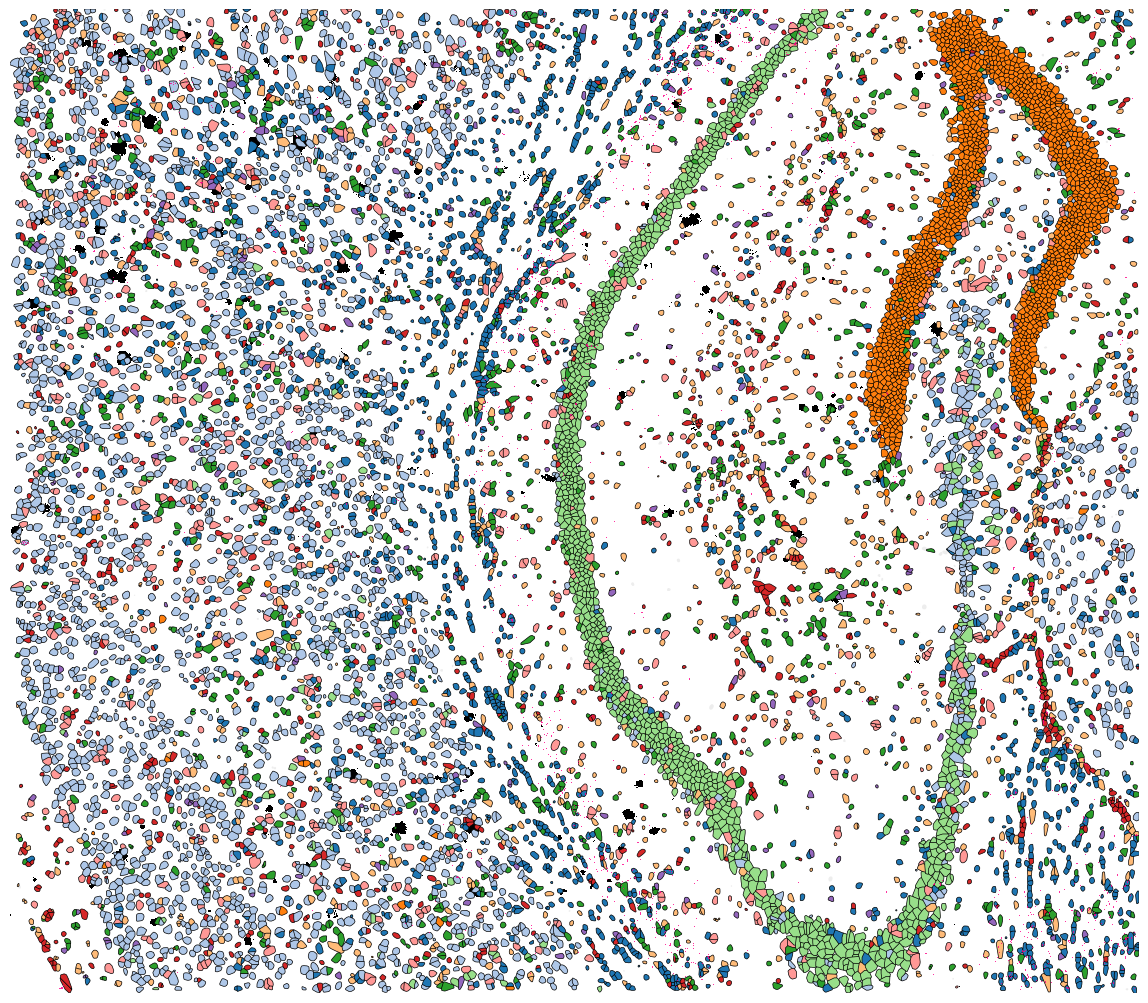

In [9]:
# Spatial cell type map (plygon)
plot_poly_cells_cluster_by_sample(adata, current_sample_id, cmap, show_plaque=True, show_tau=True, 
                                save_as_real_size=True, linewidth=0.5, rescale_colors=False,
                                figscale=3, save=False, show=True, output_dir=figure_path)

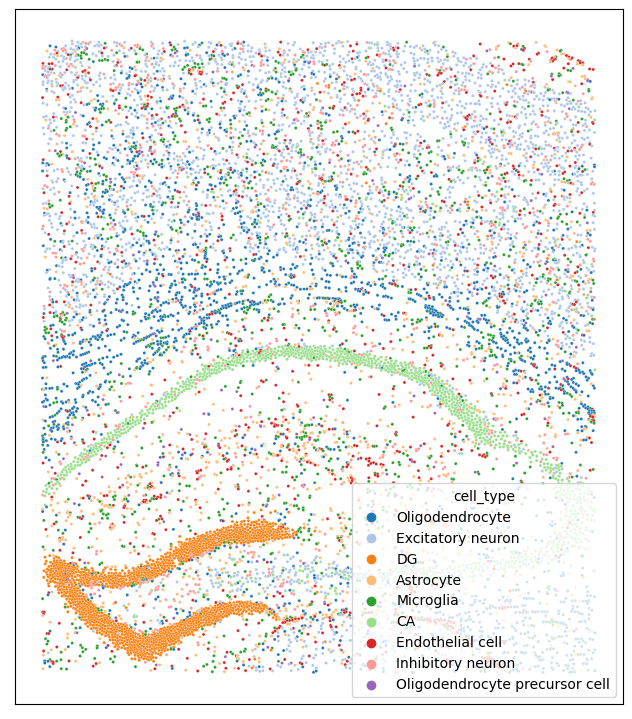

In [10]:
# Spatial cell type map (spots)
fig_size = np.array([adata.obs['x'].max(), adata.obs['y'].max()]) / 10000 * 4
fig, ax = plt.subplots(figsize=fig_size)
g = sns.scatterplot(x='x', y='y', hue='cell_type', 
                    palette=cpl,
                    data=adata.obs, 
                    s=5,
                    ax=ax)
g.invert_yaxis()
g.axes.xaxis.set_visible(False)
g.axes.yaxis.set_visible(False)